<center>
<h1>CSE 6363-007: Machine Learning Assignment 3</h1> 
    <h2>Name: Ananthula, Vineeth Kumar. UTA ID: 1001953922</h2>
</center>
    

# Non-Linear SVM


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting.decision_regions import plot_decision_regions

def linear_kernel(x1, x2):
    return x1.T @ x2
  
def poly_kernel(x1, x2):
    return (np.dot(x1, x2.T) + 1)**2     # d is by default 2


class svm():
    def __init__(self, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self._kernel = kernel
        self._tol = tol
        self._maxiter = maxiter
        
        if self._kernel == 'linear':
            self._k = linear_kernel
          
        elif self._kernel == 'poly':
            self._k = poly_kernel
        
        self._c = c
        
    def _init_params(self):
        self._error_cache = np.zeros(self._data.shape[0])
        self._alphas = np.ones(self._data.shape[0]) * .1
        self._b = 0
        
        # if self._kernel == 'linear':
        #     self._weights = np.random.rand(self._data.shape[1])
        self._weights = np.random.rand(self._data.shape[1])
  

    def predict_score(self, x):
        """Predicts a raw score (not classification)
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        u = 0
        if self._kernel == 'linear':
            u = self._weights @ x.T - self._b
        else:
            for i in range(self._data.shape[0]):
                u += self._targets[i] * self._alphas[i] * self._k(self._data[i], x)
            u -= self._b

        return u
        
    def predict(self, x):
        """Classifies input samples.
        
        Arguments
            x, array (batch_size, n_features) - input samples.
        """
        score = self.predict_score(x)

        if type(score) is np.ndarray:
            score[score < 0] = -1
            score[score >= 0] = 1

            return score
        else:
            return -1 if score < 0 else 1

    def smo_step(self, i1, i2):
        if i1 == i2:
            return 0

        x1 = self._data[i1]
        x2 = self._data[i2]
        y1 = self._targets[i1]
        y2 = self._targets[i2]
        alpha1 = self._alphas[i1]
        alpha2 = self._alphas[i2]

        # Compute errors for x1 and x2
        e1 = self.predict_score(x1) - y1
        e2 = self.predict_score(x2) - y2

        s = y1 * y2

        if s == 1:
            L = max(0, alpha2 + alpha1 - self._c)
            H = min(self._c, alpha2 + alpha1)
        else:
            L = max(0, alpha2 - alpha1)
            H = min(self._c, self._c + alpha2 - alpha1)

        if L == H:
            return 0

        k11 = self._k(x1, x1)
        k22 = self._k(x2, x2)
        k12 = self._k(x1, x2)

        eta = k11 + k22 - 2 * k12

        if eta > 0:
            a2 = alpha2 + y2 * (e1 - e2) / eta
            if a2 <= L:
                a2 = L
            elif a2 >= H:
                a2 = H
        # TODO: the negative case
        else:
            L1 = alpha1 + s*(alpha2-L)
            H1 = alpha1 + s*(alpha2-H)

            f1 = y1*(e1+self._b) - alpha1*k11 - s*alpha2*k12
            f2 = y2*(e2+self._b) - alpha2*k22 - s*alpha1*k12

            Lobj = L1*f1 + L*f2 + s*L1*L*k12 + 0.5*L*L*k22 + 0.5*L1*L1*k11
            Hobj = H1*f1 + H*f2 + s*H1*H*k12 + 0.5*H*H*k22 + 0.5*H1*H1*k11

            if Lobj < Hobj- (1e-3):
                a2 = L
            elif Lobj > Hobj+ (1e-3):
                a2 = H 
            else:
                a2 = alpha2

            # print(f"[DEBUG] smo_step: eta = {eta}")
            
        if np.abs(a2 - alpha2) < 1e-3 * (a2 + alpha2 + 1e-3):
            return 0

        a1 = alpha1 + s * (alpha2 - a2)

        # Update threshold to reflect change in Lagrange multipliers
        b1 = e1 + y1 * (a1 - alpha1) * k11 + y2 * (a2 - alpha2) * k12 + self._b
        b2 = e2 + y1 * (a1 - alpha1) * k12 + y2 * (a2 - alpha2) * k22 + self._b
        self._b = (b1 + b2) / 2

        # Update weight vector to reflect change in a1 & a2, if SVM is linear

        # if self._kernel == 'linear':
        #     self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        self._weights = np.sum((self._targets * self._alphas)[:, None] * self._data, axis=0)
        
        # Store a1 and a2 in alpha array
        self._alphas[i1] = a1
        self._alphas[i2] = a2

        # update error cache using new multipliers
        for i in range (self._data.shape[0]):
            self._error_cache[i] = self.predict_score(self._data[i]) - self._targets[i]

        return 1

    def examine(self, i2):
        x2 = self._data[i2]
        y2 = self._targets[i2]
        alpha2 = self._alphas[i2]
        e2 = self.predict_score(x2) - y2
        r2 = e2 * y2

        # Heuristic for picking the first multiplier
        if (r2 < -self._tol and alpha2 < self._c) or (r2 > self._tol and alpha2 > 0):
            f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]

            if len(f_idxs) > 1:
                # Hueristic for second multiplier: get i1 with lowest absolute error |e1 - e2|

                # TODO: Clean this up
                if e2 > 0:
                    min_error = 999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error < min_error:
                            min_error = error
                            i1 = v
                else:
                    max_error = -999999
                    for i, v in enumerate(f_idxs):
                        if v == i2:
                            continue

                        if self._error_cache[v] == 0:
                            self._error_cache[v] = self.predict_score(self._data[v]) - self._targets[v]
                        error = np.abs(e2 - self._error_cache[v])

                        if error > max_error:
                            max_error = error
                            i1 = v

                if self.smo_step(i1, i2):
                    return 1
                
                # Loop over all non-zero and non-C alpha, starting at random point
                for i, v in enumerate(np.random.permutation(f_idxs)):
                    if self.smo_step(v, i2):
                        return 1
                
                # Loop over all possible i1, starting at a random point
                for i, v in enumerate(np.random.permutation(range(self._data.shape[0]))):
                    if v == i2:
                        continue
                    if self.smo_step(v, i2):
                        return 1
                
        return 0
    
    def fit(self, data, targets):
        self._data = data
        self._targets = targets
        
        self._init_params()
        
        n_changed = 0
        examine_all = True
        n_iter = 0
        
        while (n_changed > 0 or examine_all is True) and n_iter < self._maxiter:
            n_changed = 0
            n_iter += 1
            
            if examine_all is True:
                # loop over all training examples
                for i in range(data.shape[0]):
                    n_changed += self.examine(i)
            else:
                # loop over examples where alpha is not 0 & not C
                f_idxs = np.where((self._alphas != 0) & (self._alphas != self._c))[0]
                for i, v in enumerate(f_idxs):
                    n_changed += self.examine(v)
            
            if examine_all is True:
                examine_all = False
            elif n_changed == 0:
                examine_all = True

## Dataset

In [2]:
n_a_samples = 50
n_b_samples = 50

a_samples = np.random.multivariate_normal([-1, 1], [[0.1, 0], [0, 0.1]], n_a_samples)
b_samples = np.random.multivariate_normal([1, -1], [[0.1, 0], [0, 0.1]], n_b_samples)
a_targets = np.ones(n_a_samples) * -1  # Samples from class A are assigned a class value of -1.
b_targets = np.ones(n_b_samples)  # Samples from class B are assigned a class value of 1.

samples = np.concatenate((a_samples, b_samples))
targets = np.concatenate((a_targets, b_targets))
print(samples.shape, targets.shape)

(100, 2) (100,)


In [3]:
model = svm(c=5.0)
model.fit(samples, targets)
print(model._weights)
print(model._b)

[ 0.69994628 -1.06193222]
-0.4016865613433002


weights=[ 0.69994628 -1.06193222]
b=-0.4016865613433002


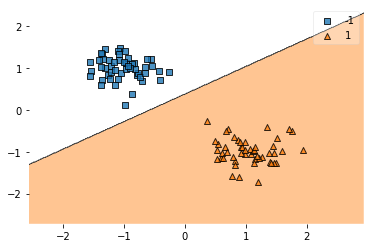

In [4]:
print(f"weights={model._weights}")
print(f"b={model._b}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), model)
fig.add_subplot(ax)
plt.show()

# SKLEARN SVC LINEAR on Linear Data

coef_=[[ 0.84392899 -0.76200398]]
intercept=[0.03560983]


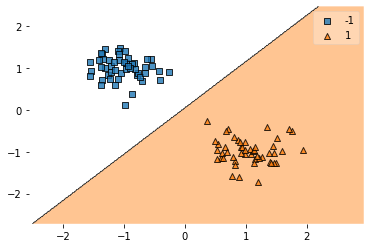

In [5]:
from sklearn.svm import LinearSVC

sk_model = LinearSVC()
sk_model.fit(samples, targets.astype(np.int32))

print(f"coef_={sk_model.coef_}")
print(f"intercept={sk_model.intercept_}")

fig = plt.figure()
ax = plot_decision_regions(samples, targets.astype(np.int32), sk_model)
fig.add_subplot(ax)
plt.show()

# Non-Linear SVM from above code on non-linear dataset

In [6]:
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [7]:
X_train, y_train = make_circles(n_samples=(45,45), factor=0.3, noise=0.05, random_state=0)
X_test, y_test = make_circles(n_samples=(5,5), factor=0.3, noise=0.05, random_state=0)

In [8]:
y_train[y_train == 0] = -1 # converting class 0 to class -1
y_test[y_test == 0] = -1

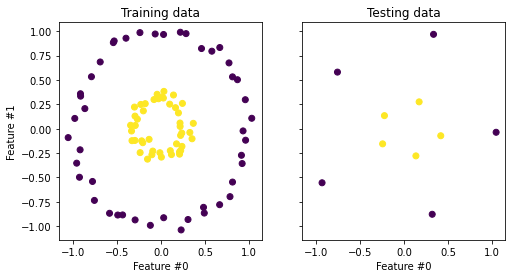

In [9]:
_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))

train_ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
train_ax.set_ylabel("Feature #1")
train_ax.set_xlabel("Feature #0")
train_ax.set_title("Training data")

test_ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
test_ax.set_xlabel("Feature #0")
_ = test_ax.set_title("Testing data")

In [10]:
model = svm(kernel='poly',c=5.0)
model.fit(X_train, y_train)
print("Non-Linear my defined SVM for kernel is poly")
print(model._weights)
print(model._b)

model1 = svm(kernel='linear',c=5.0)
model1.fit(X_train, y_train)
print("Non-Linear my defined SVM for kernel is linear")
print(model1._weights)
print(model1._b)

Non-Linear my defined SVM for kernel is poly
[0.08116281 0.04132347]
-1.4282862149557538
Non-Linear my defined SVM for kernel is linear
[-1.44347712  1.06244932]
-1.3211635066932181


Non-Linear my defined SVM for kernel is poly
weights=[0.08116281 0.04132347]
b=-1.4282862149557538


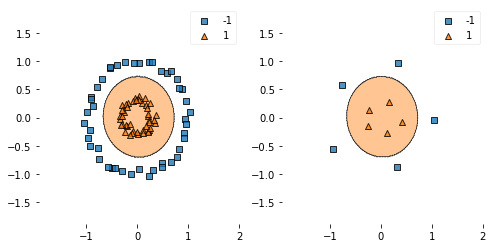

In [11]:
print("Non-Linear my defined SVM for kernel is poly")
print(f"weights={model._weights}")
print(f"b={model._b}")

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))


plt.subplot(1,2,1)
train = plot_decision_regions(X_train, y_train.astype(np.int32), model)


plt.subplot(1,2,2)
test = plot_decision_regions(X_test, y_test.astype(np.int32), model)

plt.show()

Non-Linear my defined SVM for kernel is linear
weights=[-1.44347712  1.06244932]
b=-1.3211635066932181


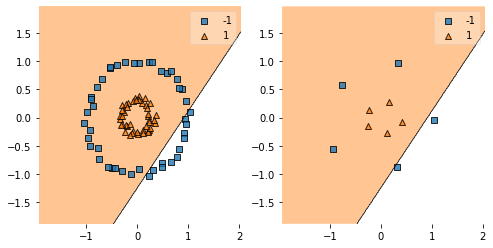

In [12]:
print("Non-Linear my defined SVM for kernel is linear")
print(f"weights={model1._weights}")
print(f"b={model1._b}")

_, (train_ax, test_ax) = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))


plt.subplot(1,2,1)
train = plot_decision_regions(X_train, y_train.astype(np.int32), model1)


plt.subplot(1,2,2)
test = plot_decision_regions(X_test, y_test.astype(np.int32), model1)

plt.show()

# Calculating accuracy for Non-Linear my defined SVM for kernel is poly and linear

In [13]:
pred = model.predict(X_test)
pred1 = model1.predict(X_test)
print("Accuracy of Non-Linear my defined SVM for kernel is poly =", accuracy_score(y_test,pred)*100)
print("Accuracy of Non-Linear my defined SVM for kernel is linear =", accuracy_score(y_test,pred1)*100)

Accuracy of Non-Linear my defined SVM for kernel is poly = 100.0
Accuracy of Non-Linear my defined SVM for kernel is linear = 70.0


# SKLEARN SVC NON-LINEAR on non-linear dataset

Accuracy of poly SKLEARN SVC NON-LINEAR on non-linear dataset =  100.0


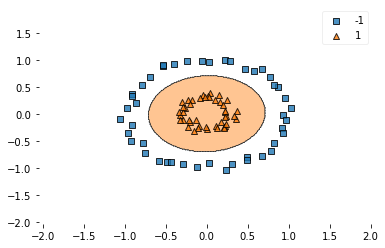

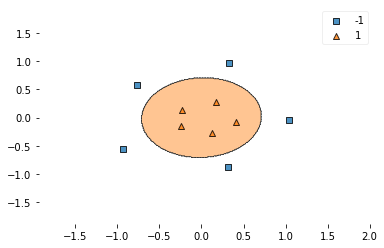

In [14]:
from sklearn import svm as sksvm


clf1 = sksvm.SVC(kernel='poly', degree=2) # built in function
clf1.fit(X_train, y_train)

y_pred_poly = model.predict(X_test)

print("Accuracy of poly SKLEARN SVC NON-LINEAR on non-linear dataset = ", accuracy_score(y_pred_poly,y_test)*100)

fig = plt.figure()
ax = plot_decision_regions(X_train, y_train.astype(np.int32), clf1)
fig.add_subplot(ax)
plt.show()

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test.astype(np.int32), clf1)
fig.add_subplot(ax)
plt.show()

# SKLEARN SVC LINEAR on non-linear dataset

Accuracy of linear SKLEARN SVC LINEAR on non-linear dataset =  100.0


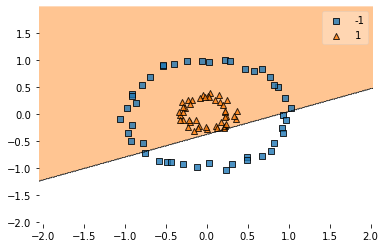

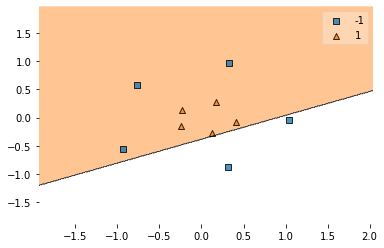

In [15]:
clf2 = sksvm.SVC(kernel='linear') # built in function
clf2.fit(X_train, y_train)

y_pred_linear = model.predict(X_test)

print("Accuracy of linear SKLEARN SVC LINEAR on non-linear dataset = ", accuracy_score(y_pred_linear,y_test)*100)

fig = plt.figure()
ax = plot_decision_regions(X_train, y_train, clf2)
fig.add_subplot(ax)
plt.show()

fig = plt.figure()
ax = plot_decision_regions(X_test, y_test, clf2)
fig.add_subplot(ax)
plt.show()

# Multi-class SVM

In [16]:
import sklearn
d = sklearn.datasets.load_iris()
data = np.array(d.data)
targets = np.array(d.target)

X_train_multi, X_test_multi, y_train_multi, y_test_multi = sklearn.model_selection.train_test_split( data, targets, test_size=0.1, random_state=0)

print(X_train_multi.shape, X_test_multi.shape, y_train_multi.shape, y_test_multi.shape)

(135, 4) (15, 4) (135,) (15,)


In [17]:
class MultiSvm():
    def __init__(self, k=3, kernel='linear', c=1.0, tol=1e-3, maxiter=1000):
        self.k = k
        self.classifiers = []
        for i in range(k):
            curr_svm = svm(kernel=kernel,c=c,tol=tol,maxiter=maxiter)
            self.classifiers.append(curr_svm)
    
    def fit(self, data, targets):
        for i in range(self.k):
            f = np.vectorize(lambda x: -1 if x != i else 1) # convert the current class to 1 and remaining to -1
            new_targets = f(targets)
            self.classifiers[i].fit(data,new_targets)
    
    def predict(self, data):
        t = self.classifiers[0].predict_score(data)
        for i in range(1,self.k):
            preds = self.classifiers[i].predict_score(data)
            t = np.vstack((t,preds))
        return t.argmax(axis=0)  # as mentioned in the assignment, took the class with largest score

                

In [18]:
multisvm = MultiSvm(k=3, kernel='linear', c=5.0)   # k here is the number of classes
multisvm.fit(X_train_multi ,y_train_multi)

# Accuracy of linear SVM with my defined Multi-class SVM

In [19]:
preds = multisvm.predict(X_test_multi)
print("Linear My Defined Multi-class SVM, accuracy =", accuracy_score(y_test_multi,preds)*100)

Linear My Defined Multi-class SVM, accuracy = 93.33333333333333


# Accuracy of non linear SVM with my defined Multi-class SVM

In [20]:
multisvm2 = MultiSvm(k=3, kernel='poly', c=5.0)   # k here is the number of classes
multisvm2.fit(X_train_multi ,y_train_multi)

In [21]:
preds = multisvm2.predict(X_test_multi)
print("Non Linear My Defined SVM multi class, accuracy =", accuracy_score(y_test_multi,preds)*100)

Non Linear My Defined SVM multi class, accuracy = 100.0


# SKLEARN SVC LINEAR AND NON-LINEAR

In [22]:
lin_clf = sksvm.LinearSVC()
lin_clf.fit(X_train_multi, y_train_multi)

pred = lin_clf.predict(X_test_multi)
print("SK Learn Linear Multi-class SVM, accuracy =",accuracy_score(y_test_multi,pred)*100)

clf = sksvm.SVC(kernel='poly',degree=2)
clf.fit(X_train_multi, y_train_multi)
pred = clf.predict(X_test_multi)
print("SK Learn non Linear Multi-class SVM, accuracy =", accuracy_score(y_test_multi,pred)*100)

SK Learn Linear Multi-class SVM, accuracy = 100.0
SK Learn non Linear Multi-class SVM, accuracy = 100.0


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


## Refereneces: https://github.com/ajdillhoff/CSE6363/blob/main/svm/smo.ipynb